<a href="https://colab.research.google.com/github/yumnazakkiya/20-09-2024/blob/main/Sesi11/New_Pilot_Class_Handling_Missing_Data_%26_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction - Data Cleaning**

Data cleaning adalah suatu prosedur untuk memastikan kebenaran, konsistensi, dan kegunaan suatu data yang ada dalam dataset. Caranya adalah dengan mendeteksi adanya error atau corrupt pada data, kemudian memperbaiki atau menghapus data jika memang diperlukan.

Proses data cleaning yang sering dilakukan adalah sebagai berikut

<li>Standarisasi Format Nilai</li>
<li>Handling Missing Value</li>
<li>Redudansi Data (Data Duplikat)</li>
<li>Handling Outlier</li>

Pada contoh dibawah ini akan dilakukan beberapa tahapan cleaning data dengan dataset yang telah disediakan

# **A. First Step : Data yang Digunakan**

Data yang digunakan adalah data telco customer yang termuat dalam google big query

In [3]:
from google.colab import auth, data_table
from google.cloud import bigquery
from pandas_gbq import to_gbq

# Proses autentikasi akun
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Buat BigQuery client
project_id = 'dqlabyumna'
client = bigquery.Client(project = project_id)

In [ ]:
# import pandas as pd

# data_telco_customer = pd.read_parquet('https://raw.githubusercontent.com/bachtiyarma/DQLab/main/data_telco_customer.parquet')
# display(data_telco_customer.head())

customer_id   open_date  gender   age  married  number_of_dependents  \
0        None        None    None  <NA>     True                     0   
1  7841-TZDMQ  24/06/2025    Male    19    False                     0   
2  0822-GAVAP  17/06/2025  Female    19    False                     0   
3  5673-FSSMF  14/07/2025  Female    19    False                     0   
4  4704-ERYFC  11/10/2023  Female    19     True                     0   

   satisfaction_score customer_status  cltv  number_of_referrals  \
0                <NA>            None  <NA>                 <NA>   
1                   3         Churned  2667                    0   
2                   1         Churned  3146                    0   
3                   3         Churned  4611                    0   
4                   1         Churned  2159                    1   

   tenure_in_months    offer phone_service internet_service internet_type  \
0              <NA>     None          None             None          None   
1                 2     None           Yes              Yes           DSL   
2                 2  Offer E            No              Yes           DSL   
3                 1  Offer E           Yes              Yes         Cable   
4                22     None           Yes              Yes   Fiber Optic   

         contract   payment_method monthly_charge total_revenue  \
0            None             None           None          None   
1  Month-to-Month      Credit Card           $ 46      $ 184,12   
2  Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3  Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4  Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   

  churn_category  churn_date                               churn_reason  
0           None        <NA>                                       None  
1          Other    29082025                                 Don't know  
2     Competitor    17082025               Competitor made better offer  
3       Attitude    17082025                 Attitude of support person  
4     Competitor    14082025  Competitor offered higher download speeds

In [ ]:
# import pandas as pd

# data_telco_customer = pd.read_parquet('https://raw.githubusercontent.com/bachtiyarma/DQLab/main/data_telco_customer.parquet')
# display(data_telco_customer.head())

customer_id   open_date  gender   age  married  number_of_dependents  \
0        None        None    None  <NA>     True                     0   
1  7841-TZDMQ  24/06/2025    Male    19    False                     0   
2  0822-GAVAP  17/06/2025  Female    19    False                     0   
3  5673-FSSMF  14/07/2025  Female    19    False                     0   
4  4704-ERYFC  11/10/2023  Female    19     True                     0   

   satisfaction_score customer_status  cltv  number_of_referrals  ...  \
0                <NA>            None  <NA>                 <NA>  ...   
1                   3         Churned  2667                    0  ...   
2                   1         Churned  3146                    0  ...   
3                   3         Churned  4611                    0  ...   
4                   1         Churned  2159                    1  ...   

   phone_service internet_service internet_type        contract  \
0           None             None          None            None   
1            Yes              Yes           DSL  Month-to-Month   
2             No              Yes           DSL  Month-to-Month   
3            Yes              Yes         Cable  Month-to-Month   
4            Yes              Yes   Fiber Optic  Month-to-Month   

    payment_method monthly_charge total_revenue churn_category churn_date  \
0             None           None          None           None       <NA>   
1      Credit Card           $ 46      $ 184,12          Other   29082025   
2  Bank Withdrawal         $ 34,7       $ 62,25     Competitor   17082025   
3  Bank Withdrawal        $ 60,15      $ 113,63       Attitude   17082025   
4  Bank Withdrawal        $ 69,25     $ 2260,42     Competitor   14082025   

                                churn_reason  
0                                       None  
1                                 Don't know  
2               Competitor made better offer  
3                 Attitude of support person  
4  Competitor offered higher download speeds  

[5 rows x 22 columns]

In [12]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Inisialisasi query yang akan dijalankan
query = """
  SELECT
    st.customer_id,
    st.open_date,
    dg.gender,
    dg.age,
    dg.married,
    dg.number_of_dependents,
    st.satisfaction_score,
    st.customer_status,
    st.cltv,
    sv.number_of_referrals,
    sv.tenure_in_months,
    sv.offer,
    sv.phone_service,
    sv.internet_service,
    sv.internet_type,
    sv.contract,
    sv.payment_method,
    sv.monthly_charge,
    sv.total_revenue,
    st.churn_category,
    st.churn_date,
    st.churn_reason
  FROM `dqlab-468906.pilotclass.telco_customer_demographics` AS dg
  LEFT JOIN `dqlab-468906.pilotclass.telco_customer_status` AS st
    ON st.customer_id = dg.customer_id
  LEFT JOIN `dqlab-468906.pilotclass.telco_customer_services` AS sv
    ON sv.customer_id = dg.customer_id
"""

# Proses ekstraksi data dari BigQuery ke pandas
data_telco_customer = client.query(query).to_dataframe()

# Tampilkan hasil
data_telco_customer.head(5)

customer_id   open_date  gender   age  married  number_of_dependents  \
0        None        None    None  <NA>     True                     0   
1  7841-TZDMQ  24/06/2025    Male    19    False                     0   
2  0822-GAVAP  17/06/2025  Female    19    False                     0   
3  5673-FSSMF  14/07/2025  Female    19    False                     0   
4  4704-ERYFC  11/10/2023  Female    19     True                     0   

   satisfaction_score customer_status  cltv  number_of_referrals  \
0                <NA>            None  <NA>                 <NA>   
1                   3         Churned  2667                    0   
2                   1         Churned  3146                    0   
3                   3         Churned  4611                    0   
4                   1         Churned  2159                    1   

   tenure_in_months    offer phone_service internet_service internet_type  \
0              <NA>     None          None             None          None   
1                 2     None           Yes              Yes           DSL   
2                 2  Offer E            No              Yes           DSL   
3                 1  Offer E           Yes              Yes         Cable   
4                22     None           Yes              Yes   Fiber Optic   

         contract   payment_method monthly_charge total_revenue  \
0            None             None           None          None   
1  Month-to-Month      Credit Card           $ 46      $ 184,12   
2  Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3  Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4  Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   

  churn_category  churn_date                               churn_reason  
0           None        <NA>                                       None  
1          Other    29082025                                 Don't know  
2     Competitor    17082025               Competitor made better offer  
3       Attitude    17082025                 Attitude of support person  
4     Competitor    14082025  Competitor offered higher download speeds

Berikut deskripsi singkat untuk tiap kolom:

* `customer_id` : ID unik untuk mengidentifikasi setiap pelanggan  
* `open_date` : Tanggal pelanggan pertama kali bergabung atau membuka akun layanan  
* `gender` : Jenis kelamin pelanggan (Male/Female)  
* `age` : Usia pelanggan dalam tahun  
* `married` : Status pernikahan pelanggan (Yes/No)  
* `number_of_dependents` : Jumlah tanggungan yang dimiliki pelanggan  
* `satisfaction_score` : Skor kepuasan pelanggan terhadap layanan (skala 1–5)  
* `customer_status` : Status pelanggan saat ini (Active, Churned, Joined)  
* `cltv` : Customer Lifetime Value, nilai total yang dihasilkan pelanggan sepanjang masa berlangganan  
* `number_of_referrals` : Jumlah referral/rekomendasi yang dilakukan pelanggan  
* `tenure_in_months` : Lama pelanggan berlangganan dalam bulan  
* `offer` : Penawaran khusus atau paket promosi yang diterima pelanggan (misalnya Offer A, Offer B, None)  
* `phone_service` : Status penggunaan layanan telepon (Yes/No)  
* `internet_service` : Status penggunaan layanan internet (Yes/No)  
* `internet_type` : Jenis layanan internet yang digunakan (DSL, Fiber Optic, Cable)  
* `contract` : Jenis kontrak pelanggan (Month-to-Month, One Year, Two Year)  
* `payment_method` : Metode pembayaran yang digunakan pelanggan (Credit Card, Bank Transfer, Electronic Check, dll.)  
* `monthly_charge` : Biaya langganan bulanan pelanggan  
* `total_revenue` : Total pendapatan yang dihasilkan dari pelanggan sejak bergabung  
* `churn_category` : Kategori alasan churn pelanggan
* `churn_date` : Tanggal kapan customer berhenti berlangganan
* `churn_reason` : Alasan spesifik pelanggan berhenti berlangganan  


In [13]:
# Memperoleh informasi umum pada data
data_telco_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           7044 non-null   object 
 1   open_date             7044 non-null   object 
 2   gender                7045 non-null   object 
 3   age                   7045 non-null   Int64  
 4   married               7046 non-null   boolean
 5   number_of_dependents  7046 non-null   Int64  
 6   satisfaction_score    7044 non-null   Int64  
 7   customer_status       7044 non-null   object 
 8   cltv                  7044 non-null   Int64  
 9   number_of_referrals   7044 non-null   Int64  
 10  tenure_in_months      7044 non-null   Int64  
 11  offer                 3166 non-null   object 
 12  phone_service         7044 non-null   object 
 13  internet_service      7044 non-null   object 
 14  internet_type         5518 non-null   object 
 15  contract             

#  **B. Standarisasi Data**

Standarisasi data perlu dilakukan, karena :

* Standarisasi membantu memastikan bahwa semua fitur atau variabel dalam dataset memiliki konsistensi
* Mempermudah dalam melakukan proses analisa
* Menyeragamkan data, skema dan metadata lain yang disimpan ke basis data

Standarisasi data yang biasanya dilakukan adalah :      
* Menyeragamkan format tanggal (YYYY-MM-DD)
* Menyeragamkan format *free text*
* Mentransformasi tipe data yang sesuai


### 👨‍💻 Task B1

Pada dataframe `data_telco_customer`, Ubah format date DD/MM/YYYY pada kolom `open_date` menjadi format YYYY-MM-DD

Note : Untuk mengubah string menjadi format datetime gunakan sintaks berikut

```
pd.to_datetime(Series, format)
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html</i></sup></a></p>

(opsional) Lalu lanjutkan dengan sintaks berikut untuk merubah format menjadi format yang diinginkan

```
Series.dt.strftime(format_yang_diinginkan)
```
<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.strftime.html">https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.strftime.html</i></sup></a></p>



In [14]:
data_telco_customer.head()

customer_id   open_date  gender   age  married  number_of_dependents  \
0        None        None    None  <NA>     True                     0   
1  7841-TZDMQ  24/06/2025    Male    19    False                     0   
2  0822-GAVAP  17/06/2025  Female    19    False                     0   
3  5673-FSSMF  14/07/2025  Female    19    False                     0   
4  4704-ERYFC  11/10/2023  Female    19     True                     0   

   satisfaction_score customer_status  cltv  number_of_referrals  \
0                <NA>            None  <NA>                 <NA>   
1                   3         Churned  2667                    0   
2                   1         Churned  3146                    0   
3                   3         Churned  4611                    0   
4                   1         Churned  2159                    1   

   tenure_in_months    offer phone_service internet_service internet_type  \
0              <NA>     None          None             None          None   
1                 2     None           Yes              Yes           DSL   
2                 2  Offer E            No              Yes           DSL   
3                 1  Offer E           Yes              Yes         Cable   
4                22     None           Yes              Yes   Fiber Optic   

         contract   payment_method monthly_charge total_revenue  \
0            None             None           None          None   
1  Month-to-Month      Credit Card           $ 46      $ 184,12   
2  Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3  Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4  Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   

  churn_category  churn_date                               churn_reason  
0           None        <NA>                                       None  
1          Other    29082025                                 Don't know  
2     Competitor    17082025               Competitor made better offer  
3       Attitude    17082025                 Attitude of support person  
4     Competitor    14082025  Competitor offered higher download speeds

In [10]:
# Convert to datetime object
data_telco_customer['open_date'] = pd.to_datetime(data_telco_customer['open_date'], format='%d/%m/%Y')

# Convert to string object
data_telco_customer['open_date'] = data_telco_customer['open_date'].dt.strftime('%Y-%m-%d')

# Tampilkan hasilnya
display(data_telco_customer.head())

ValueError: time data "2025-06-24" doesn't match format "%d/%m/%Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [15]:
# Convert to datetime object
data_telco_customer['open_date'] = pd.to_datetime(data_telco_customer['open_date'], format='%d/%m/%Y')

# Tampilkan hasilnya
display(data_telco_customer.head())

customer_id  open_date  gender   age  married  number_of_dependents  \
0        None        NaT    None  <NA>     True                     0   
1  7841-TZDMQ 2025-06-24    Male    19    False                     0   
2  0822-GAVAP 2025-06-17  Female    19    False                     0   
3  5673-FSSMF 2025-07-14  Female    19    False                     0   
4  4704-ERYFC 2023-10-11  Female    19     True                     0   

   satisfaction_score customer_status  cltv  number_of_referrals  \
0                <NA>            None  <NA>                 <NA>   
1                   3         Churned  2667                    0   
2                   1         Churned  3146                    0   
3                   3         Churned  4611                    0   
4                   1         Churned  2159                    1   

   tenure_in_months    offer phone_service internet_service internet_type  \
0              <NA>     None          None             None          None   
1                 2     None           Yes              Yes           DSL   
2                 2  Offer E            No              Yes           DSL   
3                 1  Offer E           Yes              Yes         Cable   
4                22     None           Yes              Yes   Fiber Optic   

         contract   payment_method monthly_charge total_revenue  \
0            None             None           None          None   
1  Month-to-Month      Credit Card           $ 46      $ 184,12   
2  Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3  Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4  Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   

  churn_category  churn_date                               churn_reason  
0           None        <NA>                                       None  
1          Other    29082025                                 Don't know  
2     Competitor    17082025               Competitor made better offer  
3       Attitude    17082025                 Attitude of support person  
4     Competitor    14082025  Competitor offered higher download speeds

Lakukan hal yang sama untuk dataframe `data_telco_customer`, Ubah format date DDMMYYYY pada kolom `churn_date` menjadi format YYYY-MM-DD



In [ ]:
# data_telco_customer['churn_date']as

In [ ]:
data_telco_customer.head(10)

customer_id   open_date  gender   age  married  number_of_dependents  \
0        None        None    None  <NA>     True                     0   
1  7841-TZDMQ  24/06/2025    Male    19    False                     0   
2  0822-GAVAP  17/06/2025  Female    19    False                     0   
3  5673-FSSMF  14/07/2025  Female    19    False                     0   
4  4704-ERYFC  11/10/2023  Female    19     True                     0   
5  4763-PGDPO  05/04/2025  Female    19    False                     0   
6  7963-GQRMY  03/05/2025  Female    19     True                     0   
7  7598-UAASY  13/06/2025    Male    19     True                     0   
8  5624-BQSSA  25/07/2025  Female    19    False                     0   
9  0697-ZMSWS  11/04/2025    Male    19    False                     0   

   satisfaction_score customer_status  cltv  number_of_referrals  \
0                <NA>            None  <NA>                 <NA>   
1                   3         Churned  2667                    0   
2                   1         Churned  3146                    0   
3                   3         Churned  4611                    0   
4                   1         Churned  2159                    1   
5                   1         Churned  4494                    0   
6                   2         Churned  4903                    1   
7                   1         Churned  4340                    1   
8                   1         Churned  4285                    0   
9                   1         Churned  2330                    0   

   tenure_in_months    offer phone_service internet_service internet_type  \
0              <NA>     None          None             None          None   
1                 2     None           Yes              Yes           DSL   
2                 2  Offer E            No              Yes           DSL   
3                 1  Offer E           Yes              Yes         Cable   
4                22     None           Yes              Yes   Fiber Optic   
5                 4     None           Yes              Yes   Fiber Optic   
6                 3  Offer E           Yes              Yes           DSL   
7                 2  Offer E           Yes              Yes   Fiber Optic   
8                 1     None           Yes               No          None   
9                 4     None           Yes              Yes   Fiber Optic   

         contract   payment_method monthly_charge total_revenue  \
0            None             None           None          None   
1  Month-to-Month      Credit Card           $ 46      $ 184,12   
2  Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3  Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4  Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   
5  Month-to-Month  Bank Withdrawal         $ 70,4      $ 515,48   
6  Month-to-Month      Credit Card         $ 44,3      $ 267,88   
7  Month-to-Month  Bank Withdrawal         $ 76,4       $ 192,8   
8  Month-to-Month      Credit Card        $ 20,95       $ 61,43   
9  Month-to-Month  Bank Withdrawal        $ 85,65      $ 366,54   

    churn_category  churn_date                               churn_reason  
0             None        <NA>                                       None  
1            Other    29082025                                 Don't know  
2       Competitor    17082025               Competitor made better offer  
3         Attitude    17082025                 Attitude of support person  
4       Competitor    14082025  Competitor offered higher download speeds  
5       Competitor     6082025              Competitor had better devices  
6            Price     6082025                         Extra data charges  
7       Competitor    14082025              Competitor had better devices  
8            Price    29082025                      Long distance charges  
9  Dissatisfaction    14082025                  Limited range of services

In [ ]:
data_telco_customer['churn_date'].astype('str').str.zfill(8)

0       0000<NA>
1       29082025
2       17082025
3       17082025
4       14082025
          ...   
7041    23082025
7042    26082025
7043    0000<NA>
7044    0000<NA>
7045    0000<NA>
Name: churn_date, Length: 7046, dtype: object

In [ ]:
data_telco_customer['churn_date'].astype('str').str.zfill(8).sample(10)

6522    0000<NA>
6179    0000<NA>
1031    08082025
3304    10082025
2983    0000<NA>
3334    05082025
6170    0000<NA>
4486    08082025
5521    0000<NA>
174     0000<NA>
Name: churn_date, dtype: object

In [ ]:
# Buat kondisi
data_telco_customer['churn_date'] = data_telco_customer['churn_date'].apply(lambda x: str(int(x)).zfill(8) if pd.notna(x) else pd.NA)

# Ubah menjadi format date
data_telco_customer['churn_date'] = pd.to_datetime(data_telco_customer['churn_date'], format='%d%m%Y')

# Tampilkan hasilnya
display(data_telco_customer)

customer_id   open_date  gender   age  married  number_of_dependents  \
0           None        None    None  <NA>     True                     0   
1     7841-TZDMQ  24/06/2025    Male    19    False                     0   
2     0822-GAVAP  17/06/2025  Female    19    False                     0   
3     5673-FSSMF  14/07/2025  Female    19    False                     0   
4     4704-ERYFC  11/10/2023  Female    19     True                     0   
...          ...         ...     ...   ...      ...                   ...   
7041  4323-SADQS  18/01/2025    Male    61     True                     6   
7042  5510-BOIUJ  21/07/2025    Male    35    False                     7   
7043  6286-ZHAOK  12/12/2023  Female    47     True                     7   
7044  6950-TWMYB  03/02/2021    Male    31     True                     8   
7045  3787-TRIAL  03/11/2023    Male    23     True                     9   

      satisfaction_score customer_status  cltv  number_of_referrals  \
0                   <NA>            None  <NA>                 <NA>   
1                      3         Churned  2667                    0   
2                      1         Churned  3146                    0   
3                      3         Churned  4611                    0   
4                      1         Churned  2159                    1   
...                  ...             ...   ...                  ...   
7041                   1         Churned  3520                    2   
7042                   3         Churned  5437                    0   
7043                   4          Stayed  3235                    6   
7044                   3          Stayed  4387                    2   
7045                   5          Stayed  4302                    1   

      tenure_in_months    offer phone_service internet_service internet_type  \
0                 <NA>     None          None             None          None   
1                    2     None           Yes              Yes           DSL   
2                    2  Offer E            No              Yes           DSL   
3                    1  Offer E           Yes              Yes         Cable   
4                   22     None           Yes              Yes   Fiber Optic   
...                ...      ...           ...              ...           ...   
7041                 7     None            No              Yes         Cable   
7042                 1     None           Yes               No          None   
7043                20  Offer D           Yes               No          None   
7044                54  Offer B           Yes              Yes   Fiber Optic   
7045                21  Offer D            No              Yes           DSL   

            contract   payment_method monthly_charge total_revenue  \
0               None             None           None          None   
1     Month-to-Month      Credit Card           $ 46      $ 184,12   
2     Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3     Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4     Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   
...              ...              ...            ...           ...   
7041  Month-to-Month  Bank Withdrawal         $ 34,5      $ 279,25   
7042  Month-to-Month      Credit Card        $ 19,25       $ 32,06   
7043  Month-to-Month  Bank Withdrawal        $ 25,55      $ 1244,4   
7044        Two Year  Bank Withdrawal        $ 79,95     $ 6883,85   
7045  Month-to-Month  Bank Withdrawal        $ 26,05      $ 565,75   

       churn_category churn_date                               churn_reason  
0                None        NaT                                       None  
1               Other 2025-08-29                                 Don't know  
2          Competitor 2025-08-17               Competitor made better offer  
3            Attitude 2025-08-17                 Attitude of support person  
4          Competitor 2025-08-14  C

### 👨‍💻 Task B2

Pada dataframe `data_telco_customer`, hapus simbol currency ($ ) pada kolom `monthly_charge` dan `total_revenue` kemudian konversi tipe datanya menjadi float

Untuk mengubah suatu string menjadi string yang lain gunakan sintaks

```
Series.str.replace(pat, repl, regex = False)
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html">https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html</i></sup></a></p>

Sedangkan untuk mengubah / mentransformasi tipedata gunakan

```
Series.astype(dtipe)
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.astype.html">https://pandas.pydata.org/docs/reference/api/pandas.Series.astype.html</i></sup></a></p>

In [ ]:
data_telco_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7044 non-null   object        
 1   open_date             7044 non-null   object        
 2   gender                7045 non-null   object        
 3   age                   7045 non-null   Int64         
 4   married               7046 non-null   boolean       
 5   number_of_dependents  7046 non-null   Int64         
 6   satisfaction_score    7044 non-null   Int64         
 7   customer_status       7044 non-null   object        
 8   cltv                  7044 non-null   Int64         
 9   number_of_referrals   7044 non-null   Int64         
 10  tenure_in_months      7044 non-null   Int64         
 11  offer                 3166 non-null   object        
 12  phone_service         7044 non-null   object        
 13  internet_service  

In [16]:
data_telco_customer
#

customer_id  open_date  gender   age  married  number_of_dependents  \
0           None        NaT    None  <NA>     True                     0   
1     7841-TZDMQ 2025-06-24    Male    19    False                     0   
2     0822-GAVAP 2025-06-17  Female    19    False                     0   
3     5673-FSSMF 2025-07-14  Female    19    False                     0   
4     4704-ERYFC 2023-10-11  Female    19     True                     0   
...          ...        ...     ...   ...      ...                   ...   
7041  4323-SADQS 2025-01-18    Male    61     True                     6   
7042  5510-BOIUJ 2025-07-21    Male    35    False                     7   
7043  6286-ZHAOK 2023-12-12  Female    47     True                     7   
7044  6950-TWMYB 2021-02-03    Male    31     True                     8   
7045  3787-TRIAL 2023-11-03    Male    23     True                     9   

      satisfaction_score customer_status  cltv  number_of_referrals  \
0                   <NA>            None  <NA>                 <NA>   
1                      3         Churned  2667                    0   
2                      1         Churned  3146                    0   
3                      3         Churned  4611                    0   
4                      1         Churned  2159                    1   
...                  ...             ...   ...                  ...   
7041                   1         Churned  3520                    2   
7042                   3         Churned  5437                    0   
7043                   4          Stayed  3235                    6   
7044                   3          Stayed  4387                    2   
7045                   5          Stayed  4302                    1   

      tenure_in_months    offer phone_service internet_service internet_type  \
0                 <NA>     None          None             None          None   
1                    2     None           Yes              Yes           DSL   
2                    2  Offer E            No              Yes           DSL   
3                    1  Offer E           Yes              Yes         Cable   
4                   22     None           Yes              Yes   Fiber Optic   
...                ...      ...           ...              ...           ...   
7041                 7     None            No              Yes         Cable   
7042                 1     None           Yes               No          None   
7043                20  Offer D           Yes               No          None   
7044                54  Offer B           Yes              Yes   Fiber Optic   
7045                21  Offer D            No              Yes           DSL   

            contract   payment_method monthly_charge total_revenue  \
0               None             None           None          None   
1     Month-to-Month      Credit Card           $ 46      $ 184,12   
2     Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3     Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4     Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   
...              ...              ...            ...           ...   
7041  Month-to-Month  Bank Withdrawal         $ 34,5      $ 279,25   
7042  Month-to-Month      Credit Card        $ 19,25       $ 32,06   
7043  Month-to-Month  Bank Withdrawal        $ 25,55      $ 1244,4   
7044        Two Year  Bank Withdrawal        $ 79,95     $ 6883,85   
7045  Month-to-Month  Bank Withdrawal        $ 26,05      $ 565,75   

       churn_category  churn_date                               churn_reason  
0                None        <NA>                                       None  
1               Other    29082025                                 Don't know  
2          Competitor    17082025               Competitor made better offer  
3            Attitude    17082025                 Attitude of support person  
4          Competitor    14082025  Competi

In [17]:
data_telco_customer.head()

#Step 1 : Delete simbol $ pada kolom monthly_changes (replace '$' dengan '' )
data_telco_customer['monthly_charge'].str.replace('$', '')

#Step 2 : Ganti simbol koma menjadi simbol titik
data_telco_customer['monthly_charge'].str.replace(',', '.')

#Step 3 : Ubah tipe data menjadi float
data_telco_customer['monthly_charge'].astype(float)

ValueError: could not convert string to float: '$ 46'

In [18]:
# Inisialisasi kolom yang akan di konversi
col_float = ['monthly_charge', 'total_revenue']
# Lakukan proses looping
for col in col_float:
    data_telco_customer[col] = data_telco_customer[col].str.replace('$', '')
    data_telco_customer[col] = data_telco_customer[col].str.replace(',', '.')
    data_telco_customer[col] = data_telco_customer[col].astype(float)
# Tampilkan hasilnya
display(data_telco_customer)

customer_id  open_date  gender   age  married  number_of_dependents  \
0           None        NaT    None  <NA>     True                     0   
1     7841-TZDMQ 2025-06-24    Male    19    False                     0   
2     0822-GAVAP 2025-06-17  Female    19    False                     0   
3     5673-FSSMF 2025-07-14  Female    19    False                     0   
4     4704-ERYFC 2023-10-11  Female    19     True                     0   
...          ...        ...     ...   ...      ...                   ...   
7041  4323-SADQS 2025-01-18    Male    61     True                     6   
7042  5510-BOIUJ 2025-07-21    Male    35    False                     7   
7043  6286-ZHAOK 2023-12-12  Female    47     True                     7   
7044  6950-TWMYB 2021-02-03    Male    31     True                     8   
7045  3787-TRIAL 2023-11-03    Male    23     True                     9   

      satisfaction_score customer_status  cltv  number_of_referrals  \
0                   <NA>            None  <NA>                 <NA>   
1                      3         Churned  2667                    0   
2                      1         Churned  3146                    0   
3                      3         Churned  4611                    0   
4                      1         Churned  2159                    1   
...                  ...             ...   ...                  ...   
7041                   1         Churned  3520                    2   
7042                   3         Churned  5437                    0   
7043                   4          Stayed  3235                    6   
7044                   3          Stayed  4387                    2   
7045                   5          Stayed  4302                    1   

      tenure_in_months    offer phone_service internet_service internet_type  \
0                 <NA>     None          None             None          None   
1                    2     None           Yes              Yes           DSL   
2                    2  Offer E            No              Yes           DSL   
3                    1  Offer E           Yes              Yes         Cable   
4                   22     None           Yes              Yes   Fiber Optic   
...                ...      ...           ...              ...           ...   
7041                 7     None            No              Yes         Cable   
7042                 1     None           Yes               No          None   
7043                20  Offer D           Yes               No          None   
7044                54  Offer B           Yes              Yes   Fiber Optic   
7045                21  Offer D            No              Yes           DSL   

            contract   payment_method  monthly_charge  total_revenue  \
0               None             None             NaN            NaN   
1     Month-to-Month      Credit Card           46.00         184.12   
2     Month-to-Month  Bank Withdrawal           34.70          62.25   
3     Month-to-Month  Bank Withdrawal           60.15         113.63   
4     Month-to-Month  Bank Withdrawal           69.25        2260.42   
...              ...              ...             ...            ...   
7041  Month-to-Month  Bank Withdrawal           34.50         279.25   
7042  Month-to-Month      Credit Card           19.25          32.06   
7043  Month-to-Month  Bank Withdrawal           25.55        1244.40   
7044        Two Year  Bank Withdrawal           79.95        6883.85   
7045  Month-to-Month  Bank Withdrawal           26.05         565.75   

       churn_category  churn_date                               churn_reason  
0                None        <NA>                                       None  
1               Other    29082025                                 Don't know  
2          Competitor    17082025               Competitor made better offer  
3            Attitude    17082025                 Attitude of support person  
4          Competi

In [19]:
data_telco_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7044 non-null   object        
 1   open_date             7044 non-null   datetime64[ns]
 2   gender                7045 non-null   object        
 3   age                   7045 non-null   Int64         
 4   married               7046 non-null   boolean       
 5   number_of_dependents  7046 non-null   Int64         
 6   satisfaction_score    7044 non-null   Int64         
 7   customer_status       7044 non-null   object        
 8   cltv                  7044 non-null   Int64         
 9   number_of_referrals   7044 non-null   Int64         
 10  tenure_in_months      7044 non-null   Int64         
 11  offer                 3166 non-null   object        
 12  phone_service         7044 non-null   object        
 13  internet_service  

### 👨‍💻 Task B3

Pada dataframe `data_telco_customer` periksa kolom gender, apakah ada sesuatu yang aneh? Jika iya apa itu

In [31]:
# Periksa kolom gender
data_telco_customer['gender'].unique()

array([nan], dtype=object)

Apa yang seharusnya dilakukan? Mengapa demikian?

In [24]:
data_telco_customer['gender'] = data_telco_customer['gender'].str.replace('Woman', 'Female')
data_telco_customer['gender'] = data_telco_customer['gender'].str.replace('Men', 'Male')

In [29]:
# Answer here
data_telco_customer['gender'] = data_telco_customer['gender'].map({'Woman': 'Female', 'Men': 'Male'})

In [30]:
data_telco_customer['gender'].unique()

array([nan], dtype=object)

---

# ** C. *Missing Data***

*Missing data*, juga dikenal sebagai data yang hilang, merujuk pada keadaan di mana tidak ada nilai yang tersedia atau tercatat untuk satu atau lebih variabel dalam kumpulan data. Dalam konteks analisis data, *missing data* terjadi ketika ada kekosongan atau ketidakhadiran informasi dalam dataset yang sedang dianalisis.

Data yang hilang dapat berupa nilai yang sebenarnya tidak diketahui atau tidak ada (misalnya, orang yang tidak merespons pertanyaan dalam survei), atau bisa juga berupa nilai yang hilang secara tidak sengaja (misalnya, kesalahan entri data)

*Missing data* dapat memiliki dampak yang signifikan pada analisis data dan interpretasi hasilnya. Ketika data yang hilang tidak diperlakukan dengan benar, dapat menyebabkan bias, pengurangan ukuran sampel, pengurangan efisiensi statistik, kesulitan dalam analisis, atau kesalahan interpretasi. Perhatikan contoh berikut :<br>

**[Contoh Kasus]** Sebuah toko ingin memeriksa seberapa besar *Salary* pelanggan mempengaruhi tingkat kumulatif *Spending Money* perminggu di tokonya. Diberikan data sebagai berikut
<center>
<table>
  <tr>
    <td align="center">Loyalty</td>
    <td align="center">Salary</td>
    <td align="center">Spend</td>
  </tr>
  <tr>
    <td align="center">Silver</td>
    <td align="center">4.500.000</td>
    <td align="center">250.000</td>
  </tr>
  <tr>
    <td align="center">Silver</td>
    <td align="center">4.750.000</td>
    <td align="center">NULL</td>
  </tr>
  <tr>
    <td align="center">Silver</td>
    <td align="center">5.200.000</td>
    <td align="center">NULL</td>
  </tr>
  <tr>
    <td align="center">Gold</td>
    <td align="center">NULL</td>
    <td align="center">110.000</td>
  </tr>
  <tr>
    <td align="center">Gold</td>
    <td align="center">NULL</td>
    <td align="center">89.000</td>
  </tr>
  <tr>
    <td align="center">Gold</td>
    <td align="center">10.000.000</td>
    <td align="center">NULL</td>
  </tr>
  <tr>
    <td align="center">Gold</td>
    <td align="center">10.750.000</td>
    <td align="center">0</td>
  </tr>
  <tr>
    <td align="center">Gold</td>
    <td align="center">11.500.000</td>
    <td align="center">800.000</td>
  </tr>
</table>
</center>

<br>

**[Jawab]** : Untuk menjawab persoalan tersebut dapat menggunakan analisa regresi sederhana

Bentuk umum Regresi Linear Sederhana adalah sebagai berikut

\begin{equation}
y = m\cdot x + b
\end{equation}

dengan :   
<ul>  
<li>𝑦 = variabel dependen</li>
<li>𝑥 = variabel independen</li>
<li>𝑚 = slope / kemiringan (angka ini menyatakan perubahan nilai Y saat kenaikan satu satuan nilai X)</li>
<li>𝑏 = intersep, angka ini menyatakan nilai 𝑦 saat nilai 𝑥 = 0</li>
</ul>

𝑚 dan 𝑏 dirumuskan sebagai berikut :

<img src="https://i.stack.imgur.com/JxedC.jpg">

Menurut kalian, apakah perhitungan diatas mungkin dilakukan jika masih mengandung data yang hilang?
<br><br>
<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/user_guide/missing_data.html">https://pandas.pydata.org/docs/user_guide/missing_data.html</i></sup></a></p>

<h3><b>👌 Simbol <i>Missing Data</i></b></h3>

Jika anda menemukan simbol seperti<br><br>
<center>
<table>
  <tr>
    <td align="center"><b>Simbol</b></td>
    <td align="center"><b>Sistem</b></td>
  </tr>
  <tr>
    <td align="center"><b>NULL</b></td>
    <td align="left">Database (SQL / NoSQL) dan beberapa bahasa pemrograman (C++, R)</td>
  </tr>
  <tr>
    <td align="center"><b>None</b></td>
    <td align="left">Python (Native)</td>
  </tr>
  <tr>
    <td align="center"><b>NA</b> atau <b>NaN</b> atau <b>NaT</b></td>
    <td align="left">Python dengan library tertentu (pandas / numpy)</td>
  </tr>
  <tr>
    <td align="center"><b>N/A</b></td>
    <td align="left">Excel</td>
  </tr>
  <tr>
    <td align="center">String Kosong, Simbol '-' atau teks lain</td>
    <td align="left">File format lain</td>
  </tr>
  <tr>
    <td align="center"><b>nil</b></td>
    <td align="left">Bahasa pemrograman Swift / Objective-C</td>
  </tr>
</table>
</center>
<br>

Maka ada data yang hilang (<i>Missing Data</i>) atau tidak terisi.


<h3><b>🗄️ Jenis <i>Missing Data</i></b></h3>

1. <b>Missing Completely at Random (MCAR)</b><br>
Misalkan pengumpulan data tentang tinggi badan dari sekelompok responden. Namun, dalam proses pengumpulan data, beberapa responden tidak mengisi pertanyaan tentang tinggi badan mereka. Setelah dianalisis, tidak ada pola yang menghubungkan data yang hilang dengan nilai variabel lainnya. Dalam hal ini, data yang hilang dapat dianggap sebagai hilang secara acak tanpa adanya keterkaitan dengan variabel yang diamati (MCAR).

2. <b>Missing at Random (MAR)</b><br>
Misalkan data pendapatan dan jenis kelamin. Jika responden pria lebih cenderung tidak memberikan informasi tentang pendapatan mereka daripada responden wanita, tetapi setelah diketahui jenis kelaminnya, ketidaklengkapan data tidak lagi berkaitan dengan pendapatan, maka hilangnya data dapat dikategorikan sebagai MAR

3. <b>Missing Not at Random (MNAR)</b><br>
Misalkan dilakukan survei tentang kebiasaan merokok di antara responden. Beberapa responden yang merokok berat mungkin enggan mengungkapkan informasi tersebut dalam survei karena merasa malu atau karena alasan lain. Dalam hal ini, data tentang kebiasaan merokok responden yang merokok berat akan cenderung hilang (MNAR) karena adanya pola tersembunyi terkait dengan variabel yang hilang (kebiasaan merokok responden).
<br>
<img src="https://raw.githubusercontent.com/bachtiyarmawork/DQLab-Project/main/Pilot%20Class%20-%20Jenis%20Missing%20Data.png" width="600" height="245">


<h3><b>🔍 Deteksi <i>Missing Data</i></b></h3>

Untuk mengetahui apakah sebuah data termasuk data yang hilang dapat menggunakan sintaks <br><br>

<center><code>DataFrame.isnull()</code> atau <code>DataFrame.isna()</code></center>

<br>Data yang ada akan diberi tanda **False** dan data yang hilang akan diberi tanda **True**<br>


docs : <i>https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html</i>

### 👨‍💻 Task C1

Pada dataframe `data_telco_customer`, lakukan pemeriksaan kolom mana saja yang mempunyai *missing value* dan berapa jumlahnya?

Note :      
Untuk memeriksa apakah suatu nilai termasuk missing data gunakan sintaks

```
DataFrame.isnull()
```

Untuk memeriksa banyak nilai null pada setiap kolom tambahkan sintaks

```
DataFrame.isnull().sum()
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html</i></sup></a></p>

In [ ]:
# Pemeriksaan nilai null pada data
data_telco_customer.isnull()

customer_id  open_date  gender    age  married  number_of_dependents  \
0            True       True    True   True    False                 False   
1           False      False   False  False    False                 False   
2           False      False   False  False    False                 False   
3           False      False   False  False    False                 False   
4           False      False   False  False    False                 False   
...           ...        ...     ...    ...      ...                   ...   
7041        False      False   False  False    False                 False   
7042        False      False   False  False    False                 False   
7043        False      False   False  False    False                 False   
7044        False      False   False  False    False                 False   
7045        False      False   False  False    False                 False   

      satisfaction_score  customer_status   cltv  number_of_referrals  \
0                   True             True   True                 True   
1                  False            False  False                False   
2                  False            False  False                False   
3                  False            False  False                False   
4                  False            False  False                False   
...                  ...              ...    ...                  ...   
7041               False            False  False                False   
7042               False            False  False                False   
7043               False            False  False                False   
7044               False            False  False                False   
7045               False            False  False                False   

      tenure_in_months  offer  phone_service  internet_service  internet_type  \
0                 True   True           True              True           True   
1                False   True          False             False          False   
2                False  False          False             False          False   
3                False  False          False             False          False   
4                False   True          False             False          False   
...                ...    ...            ...               ...            ...   
7041             False   True          False             False          False   
7042             False   True          False             False           True   
7043             False  False          False             False           True   
7044             False  False          False             False          False   
7045             False  False          False             False          False   

      contract  payment_method  monthly_charge  total_revenue  churn_category  \
0         True            True            True           True            True   
1        False           False           False          False           False   
2        False           False           False          False           False   
3        False           False           False          False           False   
4        False           False           False          False           False   
...        ...             ...             ...            ...             ...   
7041     False           False           False          False           False   
7042     False           False           False          False           False   
7043     False           False           False          False            True   
7044     False           False           False          False            True   
7045     False           False           False          False            True   

      churn_date  churn_reason  
0           True          True  
1          False         False  
2          False         False  
3          False         False  
4          False         False  
...          ...           ...  
7041       Fals

In [ ]:
# Perhitungan banyak nilai null pada data
jumlah_null = data_telco_customer.isnull().sum()
jumlah_null

customer_id                2
open_date                  2
gender                     1
age                        1
married                    0
number_of_dependents       0
satisfaction_score         2
customer_status            2
cltv                       2
number_of_referrals        2
tenure_in_months           2
offer                   3880
phone_service              2
internet_service           2
internet_type           1528
contract                   2
payment_method             2
monthly_charge             2
total_revenue              2
churn_category          5178
churn_date              5178
churn_reason            5178
dtype: int64

### 👨‍💻 Task C2

Pada dataframe `data_telco_customer`, tampilkan semua data dimana kolom customer_id nya kosong / berupa missing value

Note :      
Untuk memeriksa nilai null pada sebuah kolom gunakan sintaks

```
Series.isnull()
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.isna.html">https://pandas.pydata.org/docs/reference/api/pandas.Series.isna.html</i></sup></a></p>

In [ ]:
# Buat kondisi dimana sale_id kosong
conditions = data_telco_customer['customer_id'].isnull()

# Tampilkan hasilnya
display(data_telco_customer[conditions])

customer_id open_date  gender   age  married  number_of_dependents  \
0           None      None    None  <NA>     True                     0   
4632        None      None  Female    69    False                     0   

      satisfaction_score customer_status  cltv  number_of_referrals  \
0                   <NA>            None  <NA>                 <NA>   
4632                <NA>            None  <NA>                 <NA>   

      tenure_in_months offer phone_service internet_service internet_type  \
0                 <NA>  None          None             None          None   
4632              <NA>  None          None             None          None   

     contract payment_method monthly_charge total_revenue churn_category  \
0        None           None           None          None           None   
4632     None           None           None          None           None   

      churn_date churn_reason  
0           <NA>         None  
4632        <NA>         None

<h3><b>💡 Mengatasi <i>Missing Data</i></b></h3>

Untuk mengatasi hilangnya beberapa data yang telah diperoleh hal ini ada beberapa cara yang bisa dilakukan, diantaranya adalah :

1. Leave as it is (dibiarkan)
2. Filling the missing value (imputasi) with statistics value or other valid value
3. Drop them (hapus row yang mengandung missing value)


<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/user_guide/missing_data.html">https://pandas.pydata.org/docs/user_guide/missing_data.html</i></sup></a></p>

<img src="https://i.imgur.com/68u0dD2.png">

<h3> <b>🚶1. <i>Leave As It Is</i></b></h3>

Mengatasi missing data dengan cara meninggalkannya begitu saja (leave as it is) atau tidak melakukan tindakan apa pun terhadap nilai yang hilang disebut dengan *ignoring missing data* atau *leave as it is* (biarkan saja). Ini berarti Anda membiarkan missing data tetap ada dalam dataset tanpa melakukan imputasi atau penghapusan.


docs : https://pandas.pydata.org/docs/user_guide/missing_data.html

<h4><b>📝 Ketentuan</i></b></h4>

Beberapa alasan umum mengapa memilih untuk membiarkan *missing data*:

* Missing data termuat pada kolom yang tidak digunakan dalam analisa data, contoh : Missing data pada Alamat rumah, hal ini dikarenakan alamat sering tidak digunakan dalam proses analisa sehingga jika kolom tersebut tidak terisi maka lebih baik untuk membiarkan saja

<h3><b>🔗2. <i>Drop Missing Value</i></b></h3>

Menghapus data dengan nilai yang hilang adalah salah satu cara untuk mengatasi missing data, tetapi keputusan ini harus dibuat dengan hati-hati dan dipertimbangkan. Namun, penting untuk mempertimbangkan konsekuensi penghapusan data, terutama jika missing data tersebut tidak bersifat acak atau jika variabel yang dihapus memiliki signifikansi dalam analisis. Seperti kehilangan informasi, mengubah total sampel, mengubah nilai statistik secara signifikan, dll.

<img src="https://i.imgur.com/tBvdfyX.png">

<h4><b>📝 Ketentuan</i></b></h4>

Beberapa alasan umum mengapa memilih untuk menghapus missing data:

* **Pentingnya Data yang Hilang**: Jika data yang hilang tidak kritis untuk tujuan analisis atau tidak memiliki dampak signifikan pada kesimpulan, beberapa orang mungkin memilih untuk menghapusnya untuk menyederhanakan analisis.

* **Ketidakberdayaan untuk Diperbaiki**: Terkadang, missing data mungkin terjadi pada variabel atau kolom yang sulit atau tidak mungkin diimputasi dengan benar. Dalam situasi seperti itu, menghapus data yang hilang mungkin menjadi alternatif yang lebih baik daripada imputasi yang tidak dapat diandalkan.

* **Ukuran Sampel yang Cukup Besar**: Jika jumlah total data sangat besar dan jumlah missing data relatif kecil, menghapusnya mungkin tidak signifikan secara statistik.

* **Konsistensi dengan Tujuan Analisis**: Jika tujuan analisis lebih fokus pada data yang lengkap dan penghapusan data yang hilang tidak mengarah pada bias yang tidak diinginkan, maka ini mungkin dianggap sebagai langkah yang wajar
<br>

**[Contoh]** : Dalam sebuah transaksi, `transaksi_id` adalah sebuah kolom dengan urgensi nilai yang tinggi. Ketidakadaan data `transaksi_id` menyebabkan kecurigaan adanya kerusakan sistem atau ditengarai adanya manipulasi data dan juga `transaksi_id` biasanya dianggap sebagai identifikasi unik dan penting dalam melacak dan menganalisis transaksi. Hal ini dikarenakan `transaksi_id` adalah kode yang di-*generate* secara otomatis oleh *system* saat transaksi terjadi. Sehingga user sering kali akan menghapus data jika transaksi_id-nya kosong.
<br>

Untuk menghapus missing data pada DataFrame gunakan sintaks

<center><code>DataFrame.dropna(subset, how)</code></center>

dengan
* **subset** adalah list kolom yang terdapat *missing data* didalamnya
* **how** dapat diisi 'any' (jika salah satu berisi null) atau 'all' (jika semuanya list kolom yang disebutkan mengandung missing data)(
<br>

docs : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

### 👨‍💻 Task C3

Pada dataframe `data_telco_customer`, hapus data dimana **customer_id** berupa missing value / NULL. Hal ini dilakukan karena data tersebut dianggap data tidak valid karena kerusakan sistem

Note :      
Untuk memeriksa nilai null pada sebuah kolom gunakan sintaks

```
DataFrame.dropna(subset)
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html</i></sup></a></p>

In [ ]:
# Periksa ukuran data sebelum di drop
data_telco_customer.shape

(7046, 22)

In [ ]:
# Lakukan proses dropna
data_telco_customer = data_telco_customer.dropna(subset=['customer_id'])

# Periksa kembali ukuran
display(data_telco_customer.shape)

(7044, 22)

In [ ]:
jumlah_null = data_telco_customer.isnull().sum()
jumlah_null

customer_id                0
open_date                  0
gender                     0
age                        0
married                    0
number_of_dependents       0
satisfaction_score         0
customer_status            0
cltv                       0
number_of_referrals        0
tenure_in_months           0
offer                   3878
phone_service              0
internet_service           0
internet_type           1526
contract                   0
payment_method             0
monthly_charge             0
total_revenue              0
churn_category          5176
churn_date              5176
churn_reason            5176
dtype: int64

<h3><b>🧩 3. <i>Imputation</i></b></h3>

Proses imputasi merujuk pada metode atau teknik untuk mengisi nilai yang hilang dalam data. Ketika kita bekerja dengan data yang tidak lengkap, di mana beberapa nilai tidak tersedia atau hilang, imputasi digunakan untuk menggantikan nilai yang hilang dengan estimasi yang masuk akal berdasarkan informasi yang ada dalam data yang lengkap.

<h4><b>📝 Ketentuan</i></b></h4>

Ada beberapa alasan mengapa proses imputasi penting:

* **Mencegah kehilangan informasi:** Ketika kita memiliki data yang hilang, menghapus baris atau kolom yang mengandung nilai yang hilang dapat mengakibatkan kehilangan informasi yang berharga. Dengan mengimputasi nilai yang hilang, kita dapat mempertahankan sebagian besar data yang tersedia dan memaksimalkan penggunaannya.

* **Mempertahankan ukuran sampel yang cukup besar:** Dalam analisis statistik, ukuran sampel yang besar sering diinginkan untuk mendapatkan hasil yang lebih dapat diandalkan dan signifikan. Dengan mengisi nilai yang hilang, kita dapat mempertahankan ukuran sampel yang cukup besar dan mengurangi bias dalam analisis.

* **Meminimalkan distorsi hasil analisis:** Jika kita memiliki data yang hilang secara acak, menghapus baris atau kolom dengan nilai yang hilang dapat menghasilkan bias dalam analisis. Dengan mengimputasi nilai yang hilang, kita dapat meminimalkan distorsi hasil analisis dan menghasilkan estimasi yang lebih akurat.

* **Mempertahankan hubungan antar variabel:** Jika kita memiliki data yang hilang dalam beberapa variabel yang saling terkait, menghapus baris atau kolom dengan nilai yang hilang dapat mengganggu hubungan antar variabel tersebut. Dengan mengimputasi nilai yang hilang, kita dapat mempertahankan hubungan antar variabel yang penting dalam analisis.

* **Memungkinkan penggunaan algoritma yang mengharuskan data lengkap:** Beberapa algoritma atau metode analisis statistik memerlukan data yang lengkap untuk memberikan hasil yang valid. Dengan mengimputasi nilai yang hilang, kita dapat memungkinkan penggunaan algoritma ini dan memperoleh hasil yang akurat.

Proses imputasi dapat dilakukan menggunakan berbagai metode, seperti imputasi sederhana (seperti mengisi nilai yang hilang dengan rata-rata atau median), metode regresi, metode MICE, atau metode lainnya yang sesuai dengan karakteristik data dan tujuan analisis.

Untuk melakukan imputasi missing data pada Series gunakan sintaks

<center><code>Series.fillna(subset, how)</code></center>

dengan
* **subset** adalah list kolom yang terdapat *missing data* didalamnya
* **how** dapat diisi 'any' (jika salah satu berisi null) atau 'all' (jika semuanya list kolom yang disebutkan mengandung missing data)(
<br>

docs : https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html

### 👨‍💻 Task C4

Pada dataframe `data_telco_customer`, isilah kolom **offer** dengan nilai 'No Offer'

Note :      
Untuk melakukan proses imputasi data gunakan sintaks berikut

```
DataFrame.fillna(value)
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html</i></sup></a></p>

In [ ]:
data_telco_customer['offer'].value_counts(dropna = False)

offer
None       3878
Offer B     825
Offer E     805
Offer D     601
Offer A     520
Offer C     415
Name: count, dtype: int64

In [ ]:
# Lakukan proses imputasi pada kolom offer
data_telco_customer.loc[:, 'offer'] = data_telco_customer['offer'].fillna('No Offer')

In [ ]:
data_telco_customer['offer'].value_counts(dropna = False)

offer
No Offer    3878
Offer B      825
Offer E      805
Offer D      601
Offer A      520
Offer C      415
Name: count, dtype: int64

---

# **D. Redudansi Data**

Redudansi data adalah duplikasi atau penyimpanan data yang sama secara berulang dalam satu atau lebih tabel, sehingga data yang sama di simpan di dalam lebih dari 1 lokasi.

Data bisa terjadi duplikasi karena kesalahan manusia (<i>Human Error</i>) atau bisa jadi karena kesalahan sistem. Untuk mengatasinya kadang perlu diperiksa terlebih dahulu baru akan dilakukan tindakan seperti membiarkan saja atau perlu di hapus

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/user_guide/duplicates.html">https://pandas.pydata.org/docs/user_guide/duplicates.html</i></sup></a></p>

### 👨‍💻 Task D1

Pada dataframe `data_telco_customer`, lakukan pemeriksaan terhadap kolom **customer_id** yang mempunyai *duplicated value* dan berapa jumlahnya?

Note :      
Untuk memeriksa banyak nilai duplikat pada kolom tertentu gunakan sintaks

```
DataFrame.duplicated(subset, keep = False).sum()
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html</i></sup></a></p>

In [ ]:
# Periksa duplikasi kolom sale_id dan hitung
data_telco_customer.duplicated(subset = ['customer_id'], keep =False)

1       False
2       False
3       False
4       False
5       False
        ...  
7041    False
7042    False
7043    False
7044    False
7045    False
Length: 7044, dtype: bool

Setelah itu tampilkan data duplikat untuk diperiksa

In [34]:
data_telco_customer.duplicated(subset = ['customer_id']).sum()

np.int64(4)

In [33]:
# Buat kondisi
conditions = data_telco_customer.duplicated(subset = ['customer_id'], keep = False)

# Tampilkan hasilnya
display(data_telco_customer[conditions])

customer_id  open_date gender   age  married  number_of_dependents  \
0           None        NaT    NaN  <NA>     True                     0   
4632        None        NaT    NaN    69    False                     0   
5290  8414-MYSHR 2025-03-25    NaN    79    False                     0   
5291  8414-MYSHR 2025-03-25    NaN    79    False                     0   
5500  2405-LBMUW 2020-07-12    NaN    25     True                     1   
5501  2405-LBMUW 2020-07-12    NaN    25     True                     1   
5502  2405-LBMUW 2020-07-12    NaN    25     True                     1   

      satisfaction_score customer_status  cltv  number_of_referrals  \
0                   <NA>            None  <NA>                 <NA>   
4632                <NA>            None  <NA>                 <NA>   
5290                   1         Churned  2834                    0   
5291                   1         Churned  2834                    0   
5500                   4          Stayed  5024                    1   
5501                   4          Stayed  5024                    1   
5502                   4          Stayed  5024                    1   

      tenure_in_months    offer phone_service internet_service internet_type  \
0                 <NA>     None          None             None          None   
4632              <NA>     None          None             None          None   
5290                 5     None           Yes              Yes   Fiber Optic   
5291                 5     None           Yes              Yes   Fiber Optic   
5500                61  Offer B            No              Yes           DSL   
5501                61  Offer B            No              Yes           DSL   
5502                61  Offer B            No              Yes           DSL   

            contract   payment_method  monthly_charge  total_revenue  \
0               None             None             NaN            NaN   
4632            None             None             NaN            NaN   
5290  Month-to-Month  Bank Withdrawal            91.4         472.70   
5291  Month-to-Month  Bank Withdrawal            91.4         472.70   
5500        One Year  Bank Withdrawal            50.7        3108.75   
5501        One Year  Bank Withdrawal            50.7        3108.75   
5502        One Year  Bank Withdrawal            50.7        3108.75   

       churn_category  churn_date         churn_reason  
0                None        <NA>                 None  
4632             None        <NA>                 None  
5290  Dissatisfaction    25082025  Network reliability  
5291  Dissatisfaction    25082025  Network reliability  
5500             None        <NA>                 None  
5501             None        <NA>                 None  
5502             None        <NA>                 None

### 👨‍💻 Task C2

Hapus row yang duplikat pada bagian customer_id dan keep bagian terakhir

Gunakan sintaks berikut untuk menghapus data duplikat

```
DataFrame.drop_duplicates(subset, keep)
```

<p align="right"><sup>docs : <i><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html">https://pandas.pydata.org/docs/reference/api/pandas.Series.drop_duplicates.html</i></sup></a></p>


In [ ]:
# Periksa ukuran data sebelum di drop
display(data_telco_customer.shape)

(7044, 22)

In [ ]:
# Hapus data duplikat pada kolom customer_id
data_telco_customer = data_telco_customer.drop_duplicates(subset = ['customer_id'])

In [ ]:
# Periksa ukuran data sebelum di drop
display(...)

(7041, 22)

In [ ]:
# Tampilkan hasil akhir data yang telah dibersihkan
data_telco_customer

customer_id   open_date  gender  age  married  number_of_dependents  \
1     7841-TZDMQ  24/06/2025    Male   19    False                     0   
2     0822-GAVAP  17/06/2025  Female   19    False                     0   
3     5673-FSSMF  14/07/2025  Female   19    False                     0   
4     4704-ERYFC  11/10/2023  Female   19     True                     0   
5     4763-PGDPO  05/04/2025  Female   19    False                     0   
...          ...         ...     ...  ...      ...                   ...   
7041  4323-SADQS  18/01/2025    Male   61     True                     6   
7042  5510-BOIUJ  21/07/2025    Male   35    False                     7   
7043  6286-ZHAOK  12/12/2023  Female   47     True                     7   
7044  6950-TWMYB  03/02/2021    Male   31     True                     8   
7045  3787-TRIAL  03/11/2023    Male   23     True                     9   

      satisfaction_score customer_status  cltv  number_of_referrals  \
1                      3         Churned  2667                    0   
2                      1         Churned  3146                    0   
3                      3         Churned  4611                    0   
4                      1         Churned  2159                    1   
5                      1         Churned  4494                    0   
...                  ...             ...   ...                  ...   
7041                   1         Churned  3520                    2   
7042                   3         Churned  5437                    0   
7043                   4          Stayed  3235                    6   
7044                   3          Stayed  4387                    2   
7045                   5          Stayed  4302                    1   

      tenure_in_months     offer phone_service internet_service internet_type  \
1                    2  No Offer           Yes              Yes           DSL   
2                    2   Offer E            No              Yes           DSL   
3                    1   Offer E           Yes              Yes         Cable   
4                   22  No Offer           Yes              Yes   Fiber Optic   
5                    4  No Offer           Yes              Yes   Fiber Optic   
...                ...       ...           ...              ...           ...   
7041                 7  No Offer            No              Yes         Cable   
7042                 1  No Offer           Yes               No          None   
7043                20   Offer D           Yes               No          None   
7044                54   Offer B           Yes              Yes   Fiber Optic   
7045                21   Offer D            No              Yes           DSL   

            contract   payment_method monthly_charge total_revenue  \
1     Month-to-Month      Credit Card           $ 46      $ 184,12   
2     Month-to-Month  Bank Withdrawal         $ 34,7       $ 62,25   
3     Month-to-Month  Bank Withdrawal        $ 60,15      $ 113,63   
4     Month-to-Month  Bank Withdrawal        $ 69,25     $ 2260,42   
5     Month-to-Month  Bank Withdrawal         $ 70,4      $ 515,48   
...              ...              ...            ...           ...   
7041  Month-to-Month  Bank Withdrawal         $ 34,5      $ 279,25   
7042  Month-to-Month      Credit Card        $ 19,25       $ 32,06   
7043  Month-to-Month  Bank Withdrawal        $ 25,55      $ 1244,4   
7044        Two Year  Bank Withdrawal        $ 79,95     $ 6883,85   
7045  Month-to-Month  Bank Withdrawal        $ 26,05      $ 565,75   

       churn_category  churn_date                               churn_reason  
1               Other    29082025                                 Don't know  
2          Competitor    17082025               Competitor made better offer  
3            Attitude    17082025                 Attitude of support person  
4          Competitor    14082025  Competitor offered higher download speeds  
5          Competitor     6082

# **Insert ke Google Big Query**
Setelah data dibersihkan, simpan datanya ke dalam sebuah table di BigQuery

docs : _https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_gbq.html_

In [ ]:
# Informasi umum
data_telco_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7041 entries, 1 to 7045
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           7041 non-null   object 
 1   open_date             7041 non-null   object 
 2   gender                7041 non-null   object 
 3   age                   7041 non-null   Int64  
 4   married               7041 non-null   boolean
 5   number_of_dependents  7041 non-null   Int64  
 6   satisfaction_score    7041 non-null   Int64  
 7   customer_status       7041 non-null   object 
 8   cltv                  7041 non-null   Int64  
 9   number_of_referrals   7041 non-null   Int64  
 10  tenure_in_months      7041 non-null   Int64  
 11  offer                 7041 non-null   object 
 12  phone_service         7041 non-null   object 
 13  internet_service      7041 non-null   object 
 14  internet_type         5515 non-null   object 
 15  contract              7041

In [ ]:
# Mapping tipe pandas → BigQuery
dtype_mapping = {
    'object': 'STRING',
    'string': 'STRING',
    'Int64': 'INT64',
    'int64': 'INT64',
    'float64': 'FLOAT64',
    'boolean': 'BOOL',
    'bool': 'BOOL',
    'datetime64[ns]': 'DATE'
}

def generate_bq_schema(df):
    schema = []
    for col, dtype in df.dtypes.items():
        dtype_str = str(dtype)
        bq_type = dtype_mapping.get(dtype_str, 'STRING')
        schema.append({'name': col, 'type': bq_type})
    return schema

In [ ]:
# Definsiikan schema di datamart
table_schema_datamart = generate_bq_schema(data_telco_customer)
table_schema_datamart

[{'name': 'customer_id', 'type': 'STRING'},
 {'name': 'open_date', 'type': 'STRING'},
 {'name': 'gender', 'type': 'STRING'},
 {'name': 'age', 'type': 'INT64'},
 {'name': 'married', 'type': 'BOOL'},
 {'name': 'number_of_dependents', 'type': 'INT64'},
 {'name': 'satisfaction_score', 'type': 'INT64'},
 {'name': 'customer_status', 'type': 'STRING'},
 {'name': 'cltv', 'type': 'INT64'},
 {'name': 'number_of_referrals', 'type': 'INT64'},
 {'name': 'tenure_in_months', 'type': 'INT64'},
 {'name': 'offer', 'type': 'STRING'},
 {'name': 'phone_service', 'type': 'STRING'},
 {'name': 'internet_service', 'type': 'STRING'},
 {'name': 'internet_type', 'type': 'STRING'},
 {'name': 'contract', 'type': 'STRING'},
 {'name': 'payment_method', 'type': 'STRING'},
 {'name': 'monthly_charge', 'type': 'STRING'},
 {'name': 'total_revenue', 'type': 'STRING'},
 {'name': 'churn_category', 'type': 'STRING'},
 {'name': 'churn_date', 'type': 'INT64'},
 {'name': 'churn_reason', 'type': 'STRING'}]

In [ ]:
# Upload ke BigQuery
to_gbq(
    data_telco_customer,
    destination_table = 'dqlabyumna.data_mentor_saya',
    project_id = 'dqlabyumna',
    if_exists = 'append',
    table_schema = table_schema_datamart
)

100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]


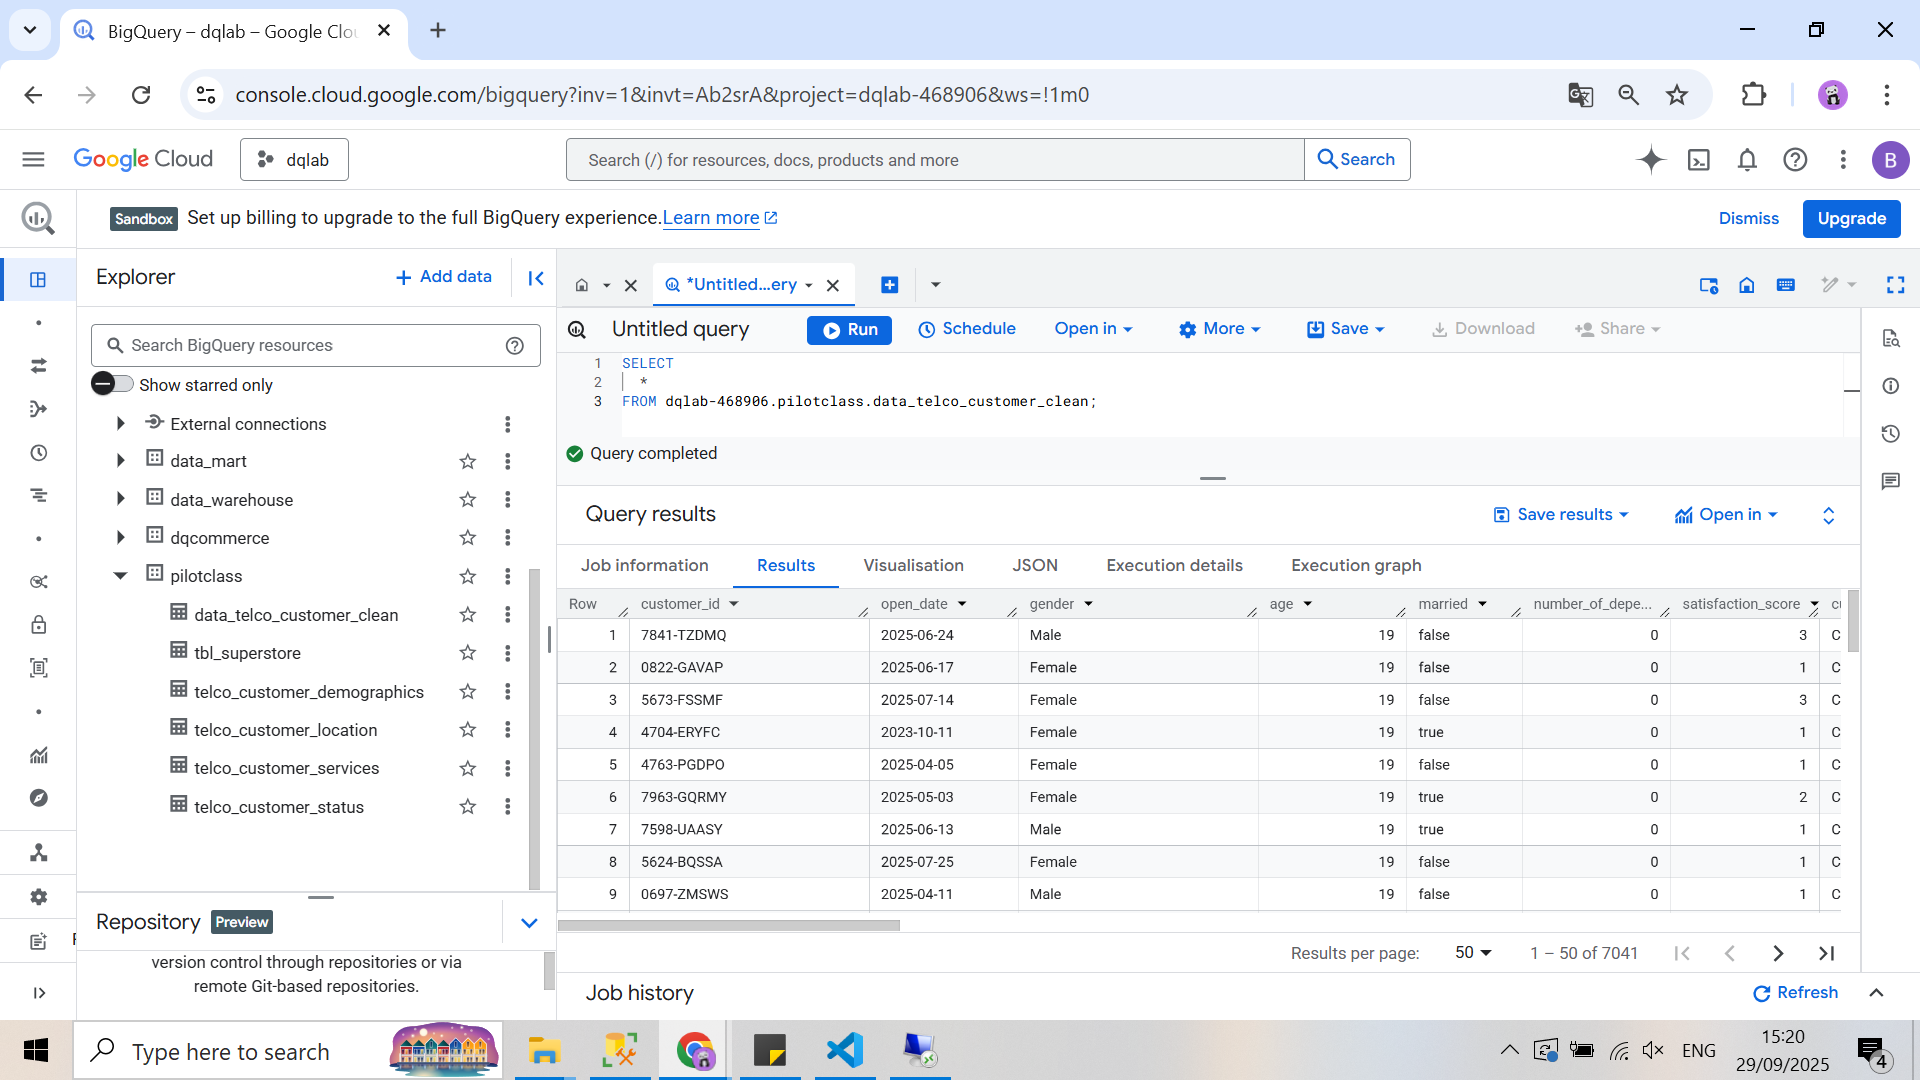

**Written By :** <br>
<a href="https://www.linkedin.com/in/zakkiya-yumna/"><img alt="Linked In Link" src="https://img.shields.io/badge/-Zakkiya%20A.%20Yumna-0072b1?style=for-the-badge&logo=None&logoColor=white" align="left"/></a>

<br><br>**for :**

<a href="https://dqlab.id/"><img src="https://dqlab.id/files/dqlab/cache/87e30118ebba5ec7d96f6ea8c9dcc10b_x_118_X_55.png" align="left" /></a>